#### Loan Default Prediction with Machine Learning
Part 3, Feature Engineering

Done with Corporate Finance Institute

#### Import Packages and Data

In [26]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Fri Apr 26 23:56:28 2024

@author: Felipe J.

Loan Default Prediction with ML pt.3, Feature Engineering.
"""

# Import Packages and Data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

loan_df = pd.read_csv('/Users/pjaram84/Desktop/Independent Pursuits/Machine Learning with CFI/Loan Default Prediction ML/data/vehicle_loans_eda.csv', index_col='UNIQUEID')


#%% Bring and Build reusable functions to explore any feature in our data set.

In [27]:
#%% Bring Reusable Functions – from EDA
# Both for Categorical & Continuous columns. These functions will be useful in investigating our features.
def explore_categorical(col_name):
    print("\n")
    print("{0} Summary:".format(col_name))
    print("\n")
    
    print("{0} Counts:".format(col_name))
    print(loan_df[col_name].value_counts())
    print("\n")
    
    print("{0} Percentage Counts:".format(col_name))
    print(loan_df[col_name].value_counts(normalize=True))
    print("\n")
    
    print("{0} Loan Default Counts:".format(col_name))
    print(loan_df.groupby(col_name)['LOAN_DEFAULT'].value_counts().unstack(level=-1))
    print("\n")
    
    print("{0} Loan Default Counts Percentage")
    print(loan_df.groupby(col_name)['LOAN_DEFAULT'].value_counts(normalize=True).unstack(level=-1))

def explore_continuous(col_name):
    # Print Statistical Summary
    print("{0} Summary:".format(col_name)) # Writes "Summary: [col_name]"
    print("\n")
    print(loan_df[col_name].describe()) # Prints the actual summary stats.
    print("\n")    
    # Look at Boxplot
    plt.figure(1)
    sns.boxplot(x=col_name, data=loan_df)
    plt.show()    
    # Look at Distribution
    plt.figure(2)
    sns.distplot(loan_df[col_name])
    plt.show()   
    # Look deeper by grouping with our target variable
    print("{0} Grouped Summary:".format(col_name))
    print("\n")
    print(loan_df.groupby('LOAN_DEFAULT')[col_name].describe())
    # Looked at grouped boxplot
    plt.figure(3)
    sns.boxplot(x=col_name, y='LOAN_DEFAULT', data=loan_df, orient='h')
    plt.show()
    

#### Feature Engineering: Binning and Grouping

In [28]:
#%% Binning (Grouping)

# explore_continuous('DISBURSED_AMOUNT') 
    # Explore 'DISBURSED_AMOUNT' column.    # Recall, we noticed previously it has large outliers.
    # Notice: The largest outlier is almost twice as much as the next large outlier, which is exterme. 
    # However, if converted to indian currency (actual for data), its about $10000-$13000 usd. Which is still reasonable.

# Get row index of that outlier in Disbursed Amount
loan_df['DISBURSED_AMOUNT'].idxmax()                # .idxmax() function outputs the index position of the row 
loan_df.loc[loan_df['DISBURSED_AMOUNT'].idxmax()]   #  with the largest value in a specified column.
# Eexploring the entire row, outlier seems reasonable since the 'ASSET_COST' = 1628992. Which is more than Disbursed Amount (loan).

# Since we decided to keep outlier, we must deal with skewing due to extreme values.
# One way to do this is with Binning.      # Create Buckets for 'Disbursed Amount'
disbursed_buckets = [13000, 30000, 45000, 60000, 75000, 150000, 1000000] # Theres also way to create buckets statistically (instead of manually).
disbursed_labels = ['13k-30k', '30k-45k', '45k-60k', '60k-75k', '75k-150k', '150k-1m'] # Again, we could've calculated binwidth automatically
                                                                                       # based on (e.g) frequency, distribution, etc.
loan_df['DISBURSED_CAT'] = pd.cut(loan_df['DISBURSED_AMOUNT'], disbursed_buckets, labels=disbursed_labels) # Binned. Grouped. Bucketed.
explore_categorical('DISBURSED_CAT') # Use our reusable function to explore our new categorical column.



DISBURSED_CAT Summary:


DISBURSED_CAT Counts:
45k-60k     126904
60k-75k      49824
30k-45k      40626
75k-150k     10871
13k-30k       4865
150k-1m         64
Name: DISBURSED_CAT, dtype: int64


DISBURSED_CAT Percentage Counts:
45k-60k     0.544293
60k-75k     0.213696
30k-45k     0.174245
75k-150k    0.046626
13k-30k     0.020866
150k-1m     0.000274
Name: DISBURSED_CAT, dtype: float64


DISBURSED_CAT Loan Default Counts:
LOAN_DEFAULT       0      1
DISBURSED_CAT              
13k-30k         4207    658
30k-45k        34323   6303
45k-60k        98830  28074
60k-75k        37056  12768
75k-150k        8070   2801
150k-1m           57      7


{0} Loan Default Counts Percentage
LOAN_DEFAULT          0         1
DISBURSED_CAT                    
13k-30k        0.864748  0.135252
30k-45k        0.844853  0.155147
45k-60k        0.778778  0.221222
60k-75k        0.743738  0.256262
75k-150k       0.742342  0.257658
150k-1m        0.890625  0.109375


#### Feature Engineering: Combining Features and Creating New Ones

In [29]:
#%% Combining Features
# Remember we also did this when we combined 'date of birth' and 'disbursed date' into a new column 'AGE'.

# Calculate Disbursal Differencem (new feature) between loan amount and Asset Cost.
loan_df['DISBURSAL_DIFFERENCE'] = loan_df['ASSET_COST'] - loan_df['DISBURSED_AMOUNT']

# Observe, there are many PRI_... and SEC_,,, columns. This means primary accounts and secondary account.    # A primary account is loan where customer is the sole 
                                                                                                             # recipient of the disbursal. Secondary account is where 
# We can create new 'Total Accounts'. (Store sum of primary and secondary accts).                            # customer is co-applicant or guarantor for the loan. 
loan_df['TOTAL_ACCTS'] = loan_df['PRI_NO_OF_ACCTS'] + loan_df['SEC_NO_OF_ACCTS']                             # Most data for SEC_... accounts if full of zeros, however 
                                                                                                             # there's still a few useful data info.
# Create 'TOTAL...' columns for all PRI_ and SEC_ columns.
# Should be 7 new coumns with the 'TOTAL_...'
loan_df['TOTAL_ACTIVE_ACCTS'] = loan_df['PRI_ACTIVE_ACCTS'] + loan_df['SEC_ACTIVE_ACCTS']
loan_df['TOTAL_OVERDUE_ACCTS'] = loan_df['PRI_OVERDUE_ACCTS'] + loan_df['SEC_OVERDUE_ACCTS']
loan_df['TOTAL_CURRENT_BALANCE'] = loan_df['PRI_CURRENT_BALANCE'] + loan_df['SEC_CURRENT_BALANCE']
loan_df['TOTAL_SANCTIONED_AMOUNT'] = loan_df['PRI_SANCTIONED_AMOUNT'] + loan_df['SEC_SANCTIONED_AMOUNT']
loan_df['TOTAL_DISBURSED_AMOUNT'] = loan_df['PRI_DISBURSED_AMOUNT'] + loan_df['SEC_DISBURSED_AMOUNT']
loan_df['TOTAL_INSTAL_AMT'] = loan_df['PRIMARY_INSTAL_AMT'] + loan_df['SEC_INSTAL_AMT']

# Drop the columns that we just replaced.
drop_cols = ['PRI_ACTIVE_ACCTS','PRI_OVERDUE_ACCTS', 'PRI_CURRENT_BALANCE', 
             'PRI_SANCTIONED_AMOUNT', 'PRI_DISBURSED_AMOUNT', 'PRIMARY_INSTAL_AMT',
             'SEC_ACTIVE_ACCTS', 'SEC_OVERDUE_ACCTS', 'SEC_CURRENT_BALANCE',  
             'SEC_SANCTIONED_AMOUNT', 'SEC_DISBURSED_AMOUNT', 'SEC_INSTAL_AMT']
loan_df = loan_df.drop(columns=drop_cols, axis=1)

# Create new column 'OVERDUE_PCT"    # This will use our new 'TOTAL ACCTS' and TOTAL OVERDUE ACCTS to caluclate (%) of active accounts that are overdue.
loan_df['OVERDUE_PCT'] = loan_df['TOTAL_OVERDUE_ACCTS'] / loan_df['TOTAL_ACCTS']
# This works but if both columns had 0s in the same row then we'd divide 0/0. Which would give us null values.
loan_df['OVERDUE_PCT'].isnull().sum()   # Check for nulls. We got 115792 new null vals.
loan_df['OVERDUE_PCT'] = loan_df['OVERDUE_PCT'].fillna(0) # fill in those missing values w/ 0.
    # Awesome. 
    # We've reduced our data from 40 columns to 31. Acquired more useful data.

#### Feature Engineering: Numerical Feature Scaling

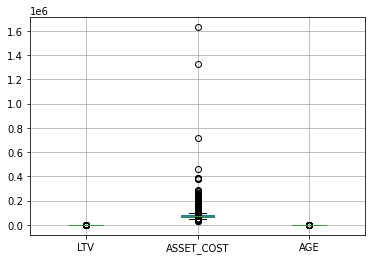

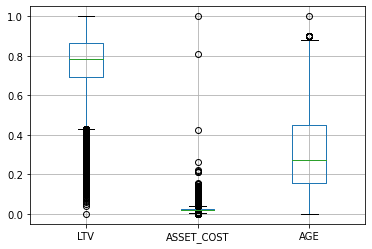

In [30]:
#%% Scaling Features
# We'll use Min Max Scaling to rescale our continuous variables into a range between 0 and 1.
# This we'll ensure our model gives equal importance to each feature.

# Create a list of numeric columns
numeric_cols = ['DISBURSED_AMOUNT','ASSET_COST', 'LTV', 'NEW_ACCTS_IN_LAST_SIX_MONTHS','DELINQUENT_ACCTS_IN_LAST_SIX_MONTHS','NO_OF_INQUIRIES', 
                'AGE', 'AVERAGE_ACCT_AGE_MONTHS', 'CREDIT_HISTORY_LENGTH_MONTHS','PERFORM_CNS_SCORE', 'TOTAL_ACCTS', 'TOTAL_ACTIVE_ACCTS', 
                'TOTAL_OVERDUE_ACCTS', 'TOTAL_CURRENT_BALANCE', 'TOTAL_SANCTIONED_AMOUNT', 'TOTAL_DISBURSED_AMOUNT', 'TOTAL_INSTAL_AMT', 'OVERDUE_PCT',
                'DISBURSAL_DIFFERENCE']
loan_df[['LTV', 'ASSET_COST', 'AGE']].boxplot() # Visualize importance of scaling
plt.show() # As you can clearly see, the scales of (e.g) these variables is vastly different. Thus, the importance of scaling.

mm_scaler = MinMaxScaler() # Initialize.
loan_df[numeric_cols] = mm_scaler.fit_transform(loan_df[numeric_cols]) # fit_transform to minmax scale all our numeric data.
# Revisit boxplot in line 132 to see if scale got fixed  
loan_df[['LTV', 'ASSET_COST', 'AGE']].boxplot()
plt.show()
    
#%% Save into new CSV
loan_df.to_csv('/Users/pjaram84/Desktop/Independent Pursuits/Machine Learning with CFI/Loan Default Prediction ML/data/vehicle_loans_feat_eng.csv')

In [32]:
#%% Summary
"""
We modified the structure of our input data to help our models
be as effective as possible. 
Performed:
- Binning
- Feature Combining (an drop others)
- Dealt with Null Values
- Scaled features and dealt with outliers 
"""

'\nWe modified the structure of our input data to help our models\nbe as effective as possible. \nPerformed:\n- Binning\n- Feature Combining (an drop others)\n- Dealt with Null Values\n- Scaled features and dealt with outliers \n'